## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import Pool,CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [54]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28)).astype(np.uint8)
test_img = np.resize(test, (test.shape[0], 28, 28)).astype(np.uint8)

## Визуализируем исходные данные

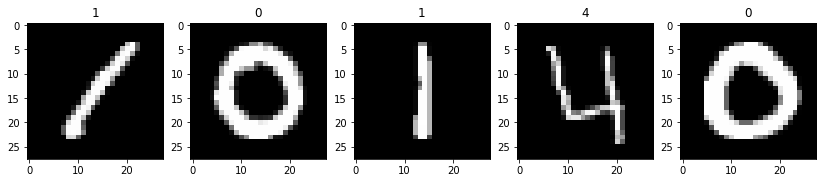

In [55]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1].astype(np.uint8));

## Рассчитаем HOG

In [56]:
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
winSize = (28,28)
blockSize = (14,14)
blockStride = (7,7)
cellSize = (14,14)
nbins = 9
signedGradients = True
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,
                        winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels,signedGradients)

In [57]:
def hogd(dataset):
    feats = []
    for img in dataset:
        img8 = img.astype(np.uint8)
        des = hog.compute(img8)
        feats.append(des)
    feats=np.array(feats)
    feats=feats.reshape(feats.shape[0],nbins*nbins)
    return feats

In [58]:
train_hog=hogd(train_img)
test_hog=hogd(test_img)

## Разбиваем выборку на обучение и валидацию, тренируем модель

In [59]:
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hog, test_size=0.2,random_state=42)

In [60]:
xx_test=Pool(data=x_val,label=y_val)
xx_train=Pool(data=x_train,label=y_train)

In [61]:
model = CatBoostClassifier(iterations=20, learning_rate=1, depth=2, loss_function='MultiClass')

In [62]:
model.fit(xx_train)

0:	learn: 1.7858846	total: 44ms	remaining: 837ms
1:	learn: 1.5113708	total: 87.5ms	remaining: 787ms
2:	learn: 1.2301377	total: 129ms	remaining: 729ms
3:	learn: 1.0418970	total: 169ms	remaining: 675ms
4:	learn: 0.8727836	total: 213ms	remaining: 638ms
5:	learn: 0.7703062	total: 254ms	remaining: 593ms
6:	learn: 0.7198352	total: 301ms	remaining: 560ms
7:	learn: 0.6267885	total: 347ms	remaining: 520ms
8:	learn: 0.5718020	total: 388ms	remaining: 475ms
9:	learn: 0.5250277	total: 428ms	remaining: 428ms
10:	learn: 0.4758338	total: 475ms	remaining: 389ms
11:	learn: 0.4357829	total: 532ms	remaining: 355ms
12:	learn: 0.4133732	total: 575ms	remaining: 309ms
13:	learn: 0.3956862	total: 614ms	remaining: 263ms
14:	learn: 0.3848052	total: 653ms	remaining: 218ms
15:	learn: 0.3638722	total: 702ms	remaining: 175ms
16:	learn: 0.3391874	total: 745ms	remaining: 131ms
17:	learn: 0.3175887	total: 788ms	remaining: 87.5ms
18:	learn: 0.3095163	total: 828ms	remaining: 43.6ms
19:	learn: 0.3027645	total: 865ms	remai

In [63]:
yy_test=model.predict(xx_test)

In [64]:
print('Accuracy: %s' % accuracy_score(y_val,yy_test))

Accuracy: 0.9091666666666667


In [65]:
print(classification_report(y_val, yy_test))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       816
         1.0       0.97      0.94      0.95       909
         2.0       0.92      0.90      0.91       846
         3.0       0.91      0.90      0.91       937
         4.0       0.91      0.90      0.90       839
         5.0       0.91      0.90      0.91       702
         6.0       0.89      0.92      0.90       785
         7.0       0.90      0.92      0.91       893
         8.0       0.86      0.86      0.86       835
         9.0       0.88      0.88      0.88       838

    accuracy                           0.91      8400
   macro avg       0.91      0.91      0.91      8400
weighted avg       0.91      0.91      0.91      8400



In [66]:
print(confusion_matrix(y_val, yy_test))

[[779   0   6   1   0   1  20   2   5   2]
 [  0 859   5   4  14   2   6  12   5   2]
 [  2   2 763  29   8   1   5  18  11   7]
 [  1   2  17 844   1  21   4  12  28   7]
 [  0   9   5   0 754   0  20   7  10  34]
 [  1   0   0  17   0 635  19   4  23   3]
 [ 19   3   0   1  18   5 723   0  14   2]
 [  1   3  20  12   6   1   0 819   3  28]
 [  8   6   7  13   5  27  17  14 721  17]
 [ 11   6   3   5  24   6   1  24  18 740]]


In [67]:
test_pred=model.predict(test_hog)

## Визуализируем предсказания

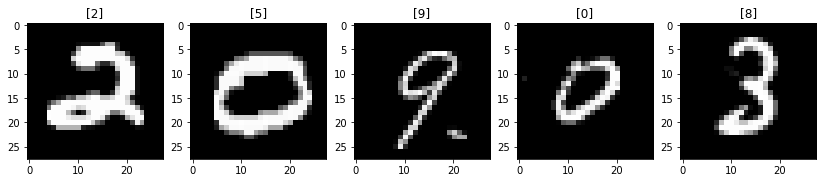

In [68]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % test_pred[i - 1].astype(np.uint8));

## Готовим файл для отправки

In [69]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(test_pred, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [70]:
!head submit.csv

ImageId,Label
1,2
2,5
3,9
4,0
5,8
6,9
7,0
8,3
9,0


In [71]:
# Your submission scored 0.90696

# А если предобработать и добавить фичей?

### Выравнивание

In [72]:
def deskew(dataset):
    dataset_st=[]
    for img in dataset:
        m = cv2.moments(img)
        if abs(m['mu02']) < 1e-2:
            # no deskewing needed. 
            return img.copy()
        # Calculate skew based on central momemts. 
        skew = m['mu11']/m['mu02']
        # Calculate affine transform to correct skewness. 
        M = np.float32([[1, skew, -0.5*28*skew], [0, 1, 0]])
        # Apply affine transform
        img_st = cv2.warpAffine(img, M, (28,28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
        dataset_st.append(img_st)
    dataset_st=np.array(dataset_st)
    return dataset_st

In [73]:
train_img_st=deskew(train_img)

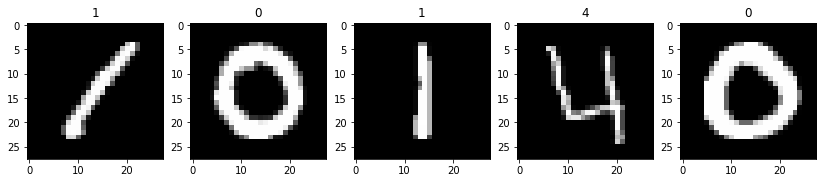

In [74]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1].astype(np.uint8));

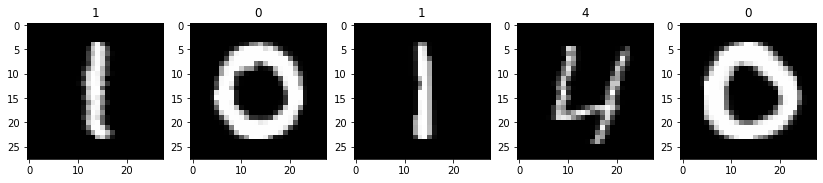

In [75]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img_st[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1].astype(np.uint8));

In [76]:
test_img_st=deskew(test_img)

#### Пробуем опять

In [77]:
train_hog_st=hogd(train_img_st)
test_hog_st=hogd(test_img_st)

#### Разбиваем выборку на обучение и валидацию, тренируем модель

In [78]:
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hog_st, test_size=0.2,random_state=42)

In [79]:
xx_test=Pool(data=x_val,label=y_val)
xx_train=Pool(data=x_train,label=y_train)

In [80]:
model1 = CatBoostClassifier(iterations=20, learning_rate=1, depth=2, loss_function='MultiClass')

In [81]:
model1.fit(xx_train)

0:	learn: 1.7369885	total: 42.6ms	remaining: 809ms
1:	learn: 1.3571535	total: 80.3ms	remaining: 723ms
2:	learn: 0.9842785	total: 119ms	remaining: 677ms
3:	learn: 0.7475807	total: 157ms	remaining: 629ms
4:	learn: 0.6055114	total: 197ms	remaining: 591ms
5:	learn: 0.5288756	total: 237ms	remaining: 552ms
6:	learn: 0.4753728	total: 290ms	remaining: 538ms
7:	learn: 0.4045382	total: 336ms	remaining: 503ms
8:	learn: 0.3583197	total: 379ms	remaining: 464ms
9:	learn: 0.3228923	total: 420ms	remaining: 420ms
10:	learn: 0.3004435	total: 459ms	remaining: 376ms
11:	learn: 0.2870203	total: 516ms	remaining: 344ms
12:	learn: 0.2719054	total: 554ms	remaining: 298ms
13:	learn: 0.2519020	total: 596ms	remaining: 256ms
14:	learn: 0.2335454	total: 641ms	remaining: 214ms
15:	learn: 0.2129661	total: 683ms	remaining: 171ms
16:	learn: 0.1997160	total: 727ms	remaining: 128ms
17:	learn: 0.1966811	total: 770ms	remaining: 85.5ms
18:	learn: 0.1876232	total: 815ms	remaining: 42.9ms
19:	learn: 0.1788184	total: 855ms	rem

In [82]:
yy_test=model1.predict(xx_test)

In [83]:
print('Accuracy: %s' % accuracy_score(y_val,yy_test))

Accuracy: 0.9395238095238095


In [84]:
print(classification_report(y_val, yy_test))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       816
         1.0       0.96      0.98      0.97       909
         2.0       0.96      0.94      0.95       846
         3.0       0.94      0.95      0.95       937
         4.0       0.96      0.94      0.95       839
         5.0       0.95      0.95      0.95       702
         6.0       0.95      0.96      0.95       785
         7.0       0.92      0.91      0.92       893
         8.0       0.91      0.90      0.91       835
         9.0       0.88      0.90      0.89       838

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



### Интенсивность написания

In [85]:
def inten(dataset):
    i=[]
    for img in dataset:
        i.append(np.median(img))
    i=np.array(i)
    return i

In [86]:
train_hog_st_int=np.concatenate((train_hog_st,np.array([inten(train_img_st)]).T),axis=1)
test_hog_st_int=np.concatenate((test_hog_st,np.array([inten(test_img_st)]).T),axis=1)

#### Разбиваем выборку на обучение и валидацию, тренируем модель

In [87]:
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hog_st_int, test_size=0.2,random_state=42)

In [88]:
xx_test=Pool(data=x_val,label=y_val)
xx_train=Pool(data=x_train,label=y_train)

In [89]:
model2 = CatBoostClassifier(iterations=20, learning_rate=1, depth=2, loss_function='MultiClass')

In [90]:
model2.fit(xx_train)

0:	learn: 1.7369885	total: 43.1ms	remaining: 819ms
1:	learn: 1.3571535	total: 80.7ms	remaining: 727ms
2:	learn: 0.9842785	total: 120ms	remaining: 678ms
3:	learn: 0.7475807	total: 157ms	remaining: 629ms
4:	learn: 0.6055114	total: 198ms	remaining: 593ms
5:	learn: 0.5288756	total: 238ms	remaining: 554ms
6:	learn: 0.4753728	total: 286ms	remaining: 531ms
7:	learn: 0.4045382	total: 336ms	remaining: 504ms
8:	learn: 0.3583197	total: 379ms	remaining: 463ms
9:	learn: 0.3228923	total: 419ms	remaining: 419ms
10:	learn: 0.3004435	total: 458ms	remaining: 375ms
11:	learn: 0.2870203	total: 505ms	remaining: 337ms
12:	learn: 0.2719054	total: 555ms	remaining: 299ms
13:	learn: 0.2519020	total: 599ms	remaining: 257ms
14:	learn: 0.2335454	total: 642ms	remaining: 214ms
15:	learn: 0.2129661	total: 684ms	remaining: 171ms
16:	learn: 0.1997160	total: 731ms	remaining: 129ms
17:	learn: 0.1966811	total: 771ms	remaining: 85.7ms
18:	learn: 0.1876232	total: 817ms	remaining: 43ms
19:	learn: 0.1788184	total: 857ms	remai

In [91]:
yy_test=model2.predict(xx_test)

In [92]:
print('Accuracy: %s' % accuracy_score(y_val,yy_test))

Accuracy: 0.9395238095238095


In [93]:
print(classification_report(y_val, yy_test))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       816
         1.0       0.96      0.98      0.97       909
         2.0       0.96      0.94      0.95       846
         3.0       0.94      0.95      0.95       937
         4.0       0.96      0.94      0.95       839
         5.0       0.95      0.95      0.95       702
         6.0       0.95      0.96      0.95       785
         7.0       0.92      0.91      0.92       893
         8.0       0.91      0.90      0.91       835
         9.0       0.88      0.90      0.89       838

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



Нет никакой разницы по сравнению с просто выравниванием.

## Готовим файл для отправки

In [94]:
test_pred2=model2.predict(test_hog_st_int)

In [95]:
with open('submit_2.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(test_pred2, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [96]:
!head submit_2.csv

ImageId,Label
1,2
2,0
3,9
4,8
5,3
6,7
7,0
8,3
9,0


In [46]:
# Your submission scored 0.93932